In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
import cv2 as cv
from PIL import Image
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.regression import MeanSquaredError as MSE
from torchmetrics.collections import MetricCollection
import gc
from torchvision.transforms import Normalize

In [9]:

train_csv = Path('nyu_data/data/nyu2_train.csv')
train_ims_path = Path('nyu_data/data/nyu2_train')
base_path = Path('nyu_data')

In [10]:

df = pd.read_csv(train_csv,header=None)
df[0] = df[0].map(lambda x:base_path/x)
df[1] = df[1].map(lambda x:base_path/x)
df.head()

,0,1
0,nyu_data/data/nyu2_train/living_room_0038_out/...,nyu_data/data/nyu2_train/living_room_0038_out/...
1,nyu_data/data/nyu2_train/living_room_0038_out/...,nyu_data/data/nyu2_train/living_room_0038_out/...
2,nyu_data/data/nyu2_train/living_room_0038_out/...,nyu_data/data/nyu2_train/living_room_0038_out/...
3,nyu_data/data/nyu2_train/living_room_0038_out/...,nyu_data/data/nyu2_train/living_room_0038_out/...
4,nyu_data/data/nyu2_train/living_room_0038_out/...,nyu_data/data/nyu2_train/living_room_0038_out/...


In [11]:
train_df, val_df = train_test_split(df,test_size=0.1,shuffle=True)
val_df, test_df = train_test_split(val_df, test_size=0.1,shuffle=True)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)
train_df=train_df[0:10000]
val_df=val_df[0:1000]
len(train_df),len(val_df), len(test_df)

(10000, 1000, 507)

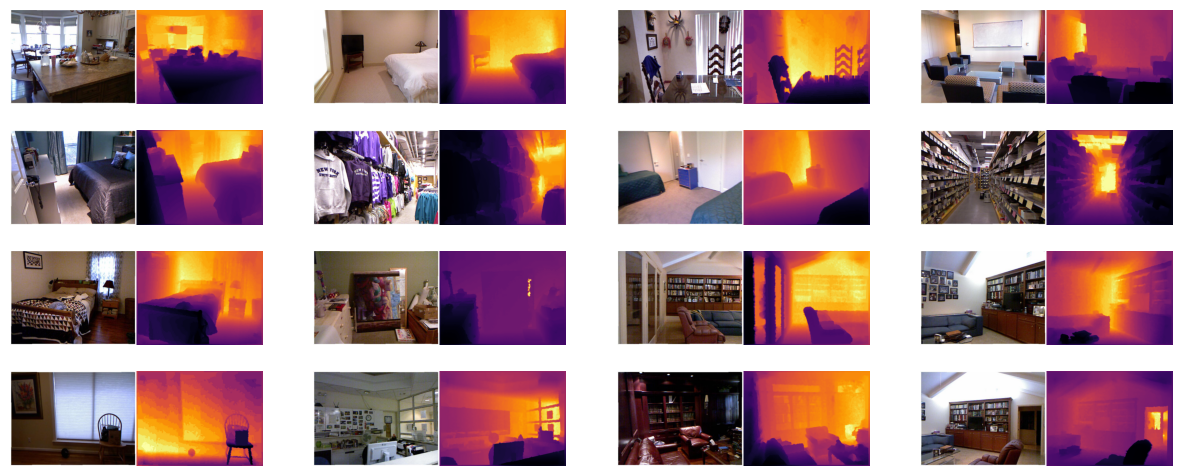

In [12]:
# Visualization helper functions
def colored_depthmap(depth, d_min=None, d_max=None, cmap=plt.cm.inferno):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:, :, :3]  # H, W, C

def merge_into_row(input, depth_target):
    input = np.array(input)
    depth_target = np.squeeze(np.array(depth_target))

    d_min = np.min(depth_target)
    d_max = np.max(depth_target)
    depth_target_col = colored_depthmap(depth_target, d_min, d_max)
    img_merge = np.hstack([input, depth_target_col])

    return img_merge

# Visualize random samples
plt.figure(figsize=(15, 6))
for i, idx in enumerate(np.random.randint(0, len(df), (16,))):
    ax = plt.subplot(4, 4, i + 1)
    image = Image.open(df.iloc[idx, 0]).convert('RGB')
    mask = Image.open(df.iloc[idx, 1]).convert('L')
    image_viz = merge_into_row(image, mask)
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

In [13]:
sample_tfms = [
    A.HorizontalFlip(),
    A.GaussNoise(p=0.2),
    A.OneOf([
        A.MotionBlur(p=.3),
        A.MedianBlur(blur_limit=3, p=0.3),
        A.Blur(blur_limit=3, p=0.5),
    ], p=0.3),
    A.RGBShift(),
    A.RandomBrightnessContrast(),
    A.RandomCrop(height=384, width=384),  # Random crop
    A.Resize(224, 224),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224,224),
    A.Normalize(always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(always_apply=True),
    ToTensorV2()
])

/Users/tueeee/anaconda3/lib/python3.11/site-packages/pydantic/main.py:426: UserWarning: Pydantic serializer warnings:
  Expected `dict[str, any]` but got `UniformParams` with value `UniformParams(noise_type=...6, 0.0784313725490196)])` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
/Users/tueeee/anaconda3/lib/python3.11/site-packages/albumentations/core/validation.py:45: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/0f/s9wq33q97413q_m4638c7wdr0000gn/T/ipykernel_16164/1951553394.py:20: UserWarning: Argument 'always_apply' is not valid and will be ignored.
  A.Normalize(always_apply=True),
/var/folders/0f/s9wq33q97413q_m4638c7wdr0000gn/T/ipykernel_16164/1951553394.py:25: UserWarning: Argument 'always_apply' is not valid and will be ignored.
  A.Normalize(always_apply=True),


In [14]:
class Dataset:
    def __init__(self,df,tfms):
        self.df = df
        self.tfms=tfms
    def open_im(self,p,gray=False):
        im = cv.imread(str(p))
        im = cv.cvtColor(im,cv.COLOR_BGR2GRAY if gray else cv.COLOR_BGR2RGB)
        return im
    
    def __len__(self,):
        return len(self.df)
    
    def __getitem__(self,idx):
        s = self.df.iloc[idx,:]
        im, dp = s[0],s[1]
        im, dp = self.open_im(im), self.open_im(dp,True)
        augs = self.tfms(image=im,mask=dp)
        im, dp = augs['image'], augs['mask'] / 255.
        return im, dp.unsqueeze(0)


train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)
test_ds = Dataset(test_df, valid_tfms)
len(train_ds), len(val_ds), len(test_ds)

(10000, 1000, 507)

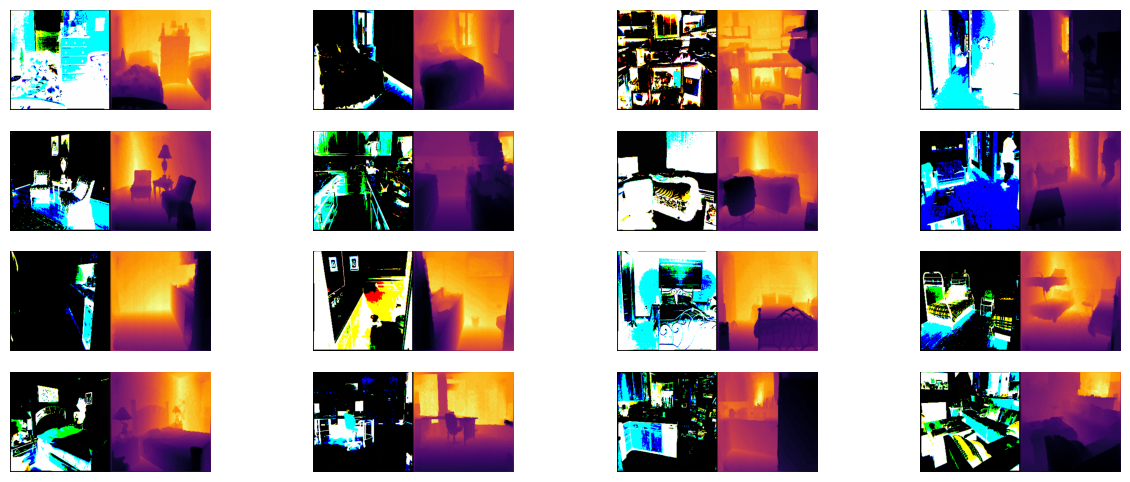

In [15]:
randoms = [test_ds[idx] for idx in range(16)]
plt.figure(figsize=(15, 6))
for i, (img,mask) in enumerate(randoms):
    ax = plt.subplot(4, 4, i + 1)
    img, mask = img.permute(1,2,0).numpy(), mask.permute(1,2,0).numpy()
    mask = colored_depthmap(np.squeeze(mask))
    image_viz = np.hstack([img,mask])
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

In [16]:
train_dl = torch.utils.data.DataLoader(train_ds,shuffle=True,batch_size=64)
val_dl = torch.utils.data.DataLoader(val_ds,shuffle=False,batch_size=64)
test_dl = torch.utils.data.DataLoader(test_ds, shuffle=True, batch_size=4)
len(train_dl), len(val_dl), len(test_dl)

(157, 16, 127)

In [20]:
import torchvision.models as models
import torch.nn as nn

class DepthUncertaintyModel(nn.Module):
    def __init__(self, backbone='resnet18'):
        super().__init__()
        self.encoder = getattr(models, backbone)(pretrained=True)
        self.encoder = nn.Sequential(*list(self.encoder.children())[:-2])  # Remove FC and pooling layers

        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # 7x7 -> 14x14
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # 14x14 -> 28x28
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # 28x28 -> 56x56
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # 56x56 -> 112x112
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # 112x112 -> 224x224
            nn.Conv2d(16, 2, kernel_size=3, padding=1)  # Final output: depth and log(variance)
        )

    def forward(self, x):
        features = self.encoder(x)
        output = self.decoder(features)
        depth, log_variance = output[:, 0:1, :, :], output[:, 1:2, :, :]
        return depth, log_variance


In [21]:
def probabilistic_loss(pred, target, log_var):
    inv_var = torch.exp(-log_var)
    mse = (target - pred)**2

    loss = 0.5 * (inv_var * mse + log_var)
    return loss.mean()


In [85]:
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DepthUncertaintyModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scaler = GradScaler()
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, depths in tqdm(train_dl):
        images, depths = images.to(device), depths.to(device)
        optimizer.zero_grad()
        
        with autocast():
            pred_depths, log_var = model(images)
            loss = probabilistic_loss(pred_depths, depths, log_var)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_dl)}")


/var/folders/0f/s9wq33q97413q_m4638c7wdr0000gn/T/ipykernel_1884/1985050652.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  0%|          | 0/157 [00:00<?, ?it/s]

/var/folders/0f/s9wq33q97413q_m4638c7wdr0000gn/T/ipykernel_1884/1985050652.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: -1.2535420746400145


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/10, Loss: -1.791148661048549


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/10, Loss: -1.973227010411062


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/10, Loss: -2.0573208734488033


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/10, Loss: -2.1127082610585886


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/10, Loss: -2.184138847764131


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/10, Loss: -2.1901408046673816


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/10, Loss: -2.2620669717242006


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/10, Loss: -2.308710340481655


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/10, Loss: -2.29984330903193


In [86]:
# Save the model's state_dict
torch.save(model.state_dict(), "depth_uncertainty_model.pth")



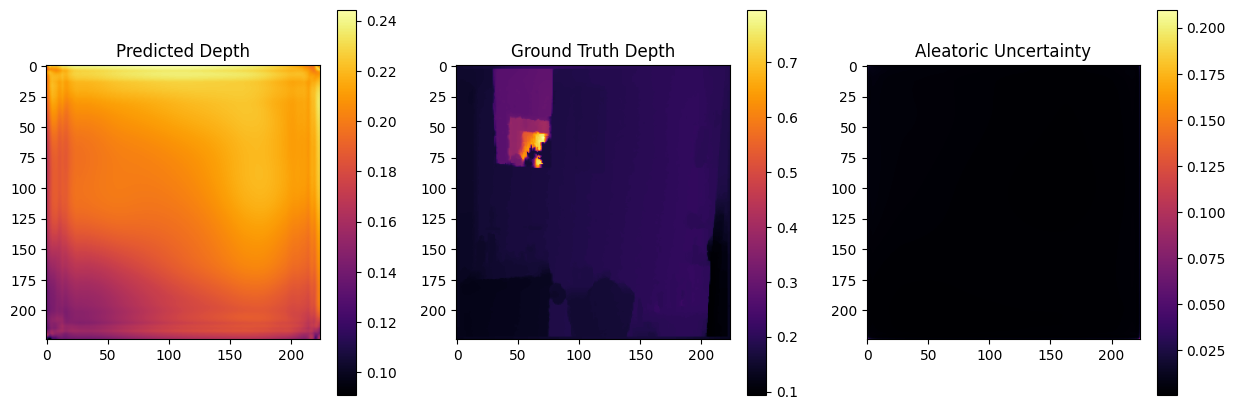

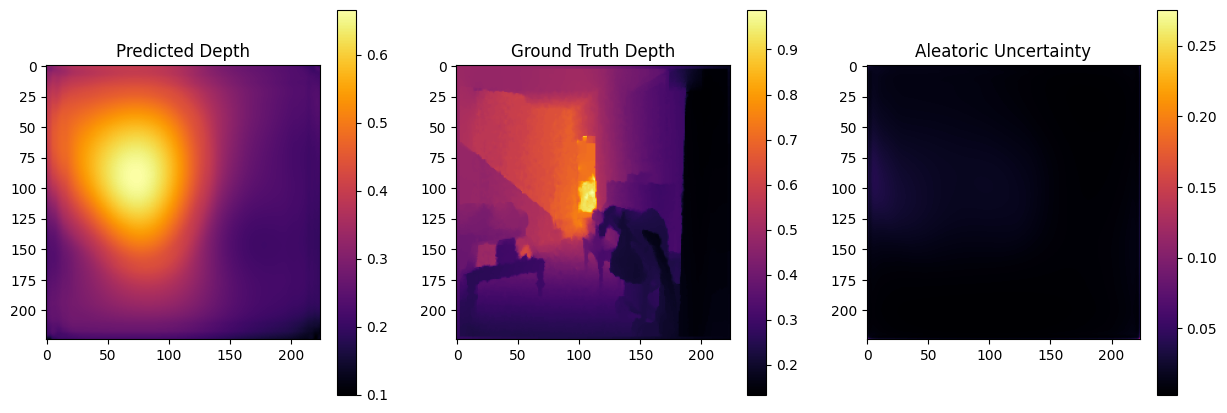

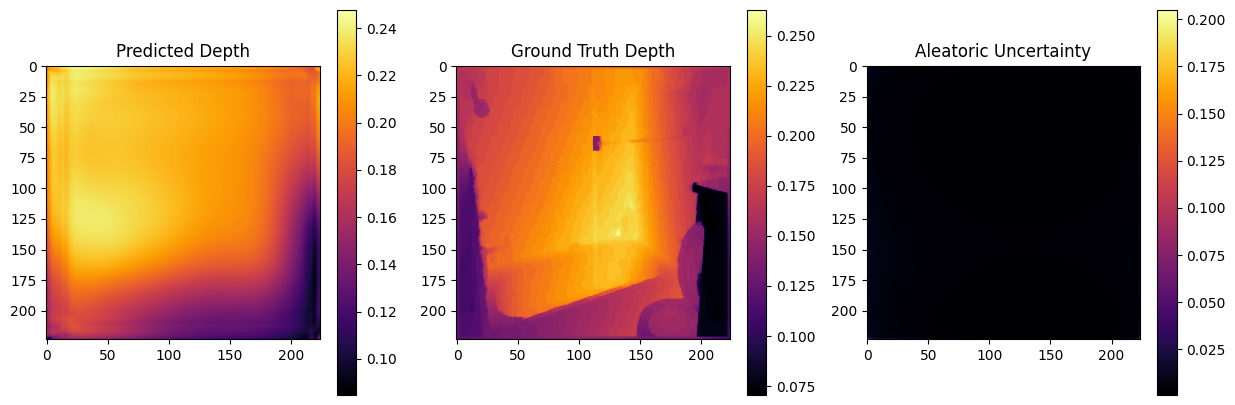

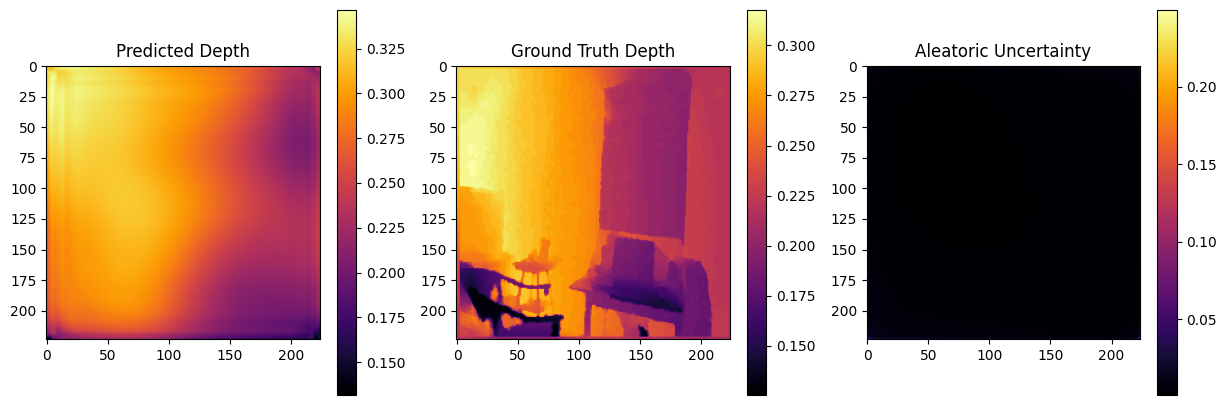

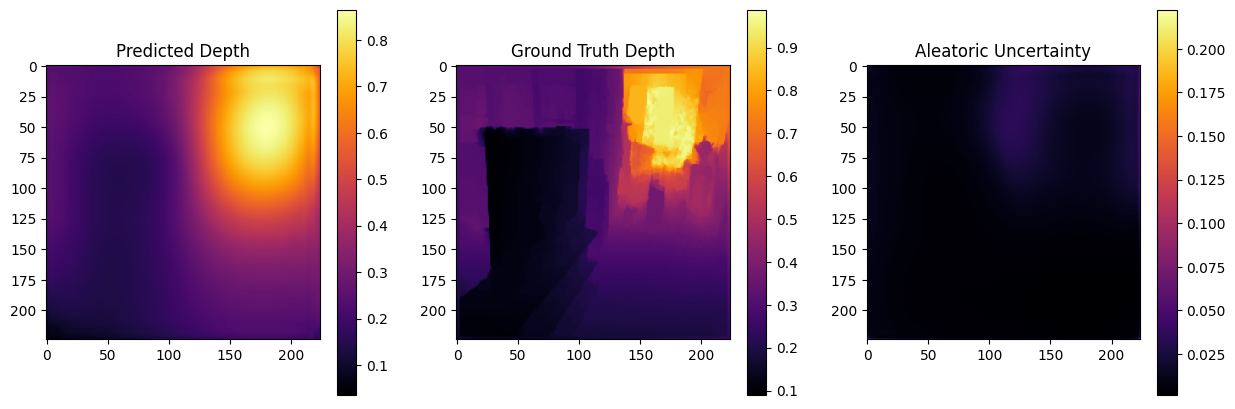

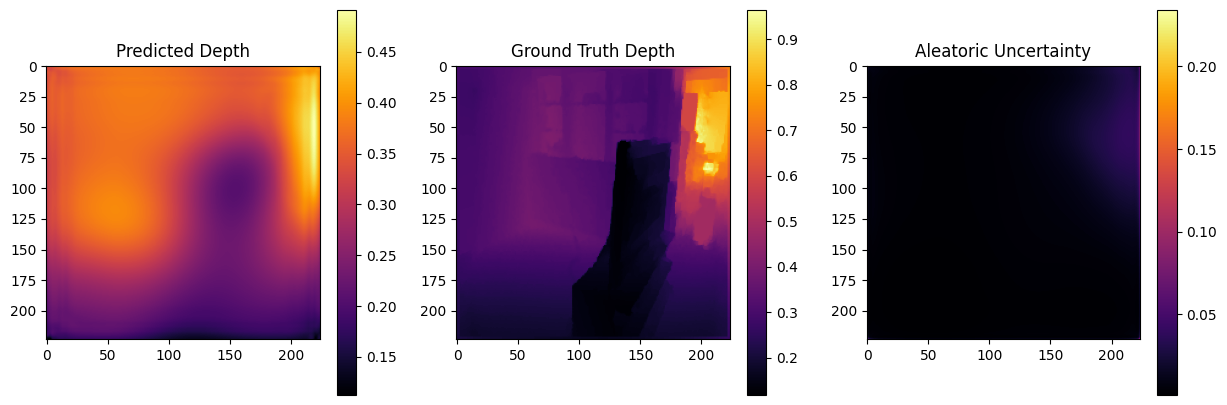

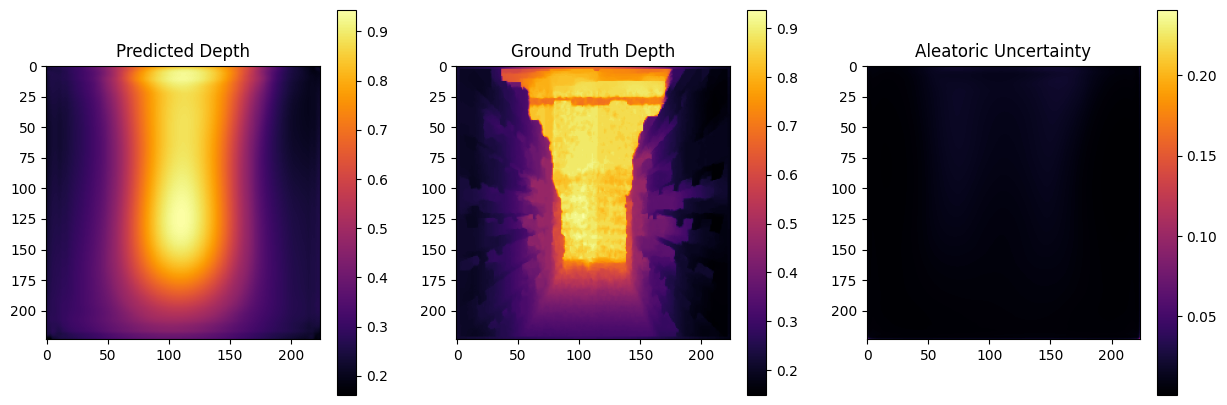

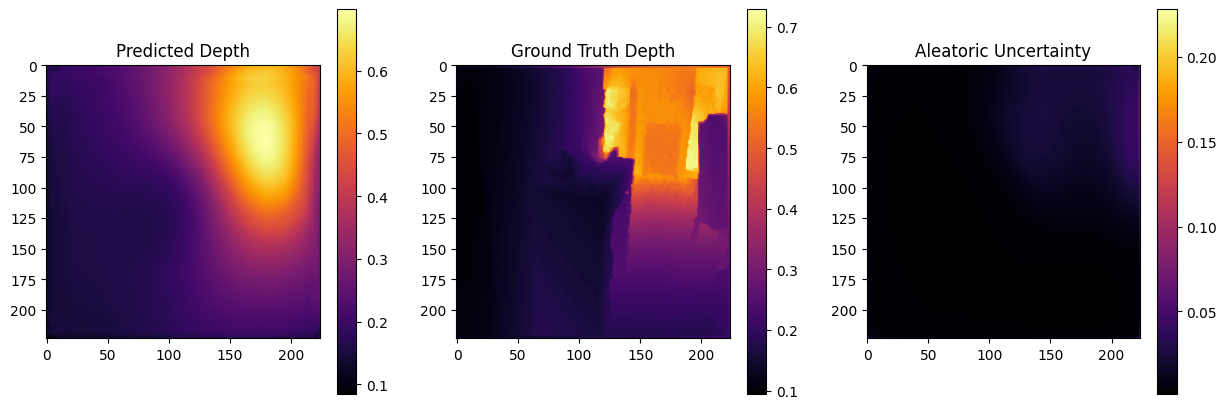

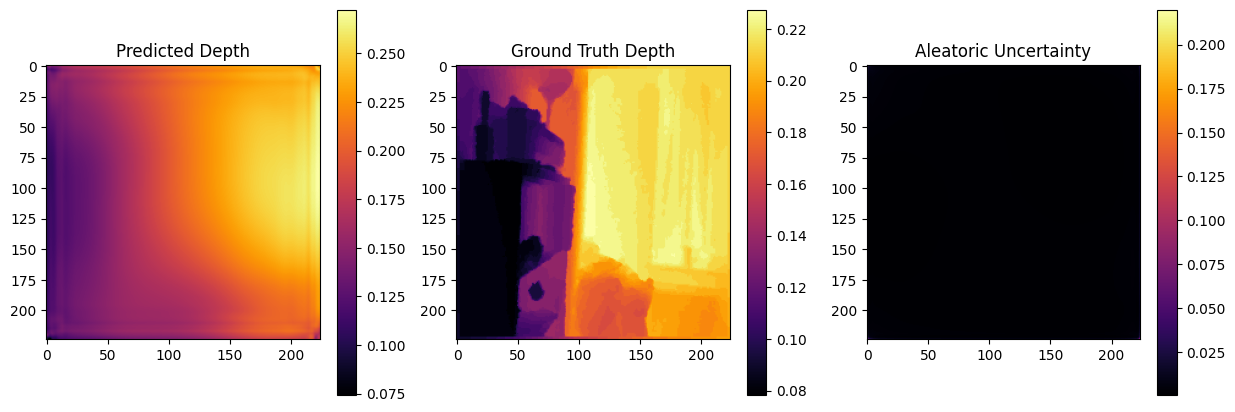

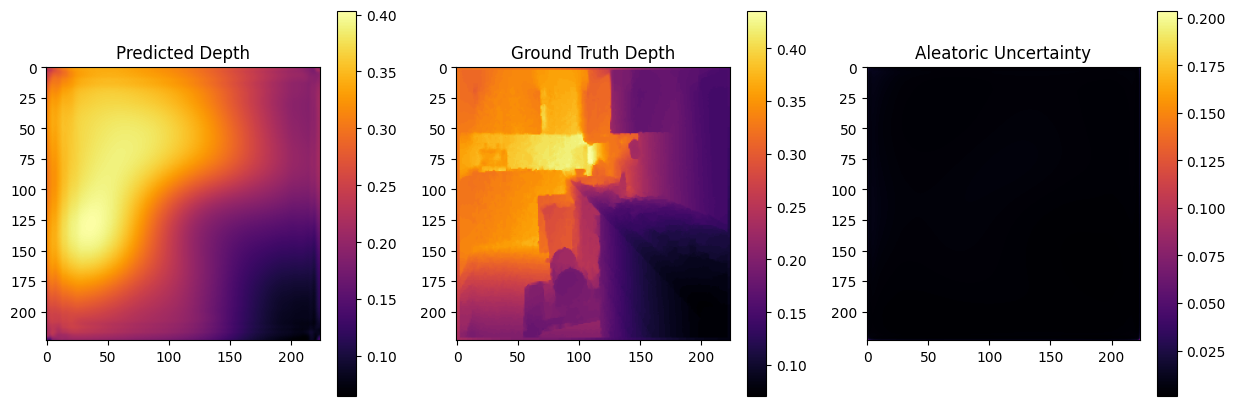

In [25]:
import cv2
def evaluate_model(model, dataloader):
    model.eval()
    with torch.no_grad():
        for images, depths in dataloader:
            images, depths = images.to(device), depths.to(device)
            pred_depths, log_var = model(images)

            # Visualize results
            for i in range(10):  # Show 4 samples
                pred = pred_depths[i].squeeze().cpu().numpy()
                refined =  cv2.bilateralFilter(pred, d=5, sigmaColor=75, sigmaSpace=75)
                uncertainty = torch.exp(log_var[i]).squeeze().cpu().numpy()
                depth_gt = depths[i].squeeze().cpu().numpy()

                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.title("Predicted Depth")
                plt.imshow(refined, cmap='inferno')
                plt.colorbar()
                
                plt.subplot(1, 3, 2)
                plt.title("Ground Truth Depth")
                plt.imshow(depth_gt, cmap='inferno')
                plt.colorbar()

                plt.subplot(1, 3, 3)
                plt.title("Aleatoric Uncertainty")
                plt.imshow(uncertainty, cmap='inferno')
                plt.colorbar()

                plt.show()
            break

evaluate_model(model, val_dl)


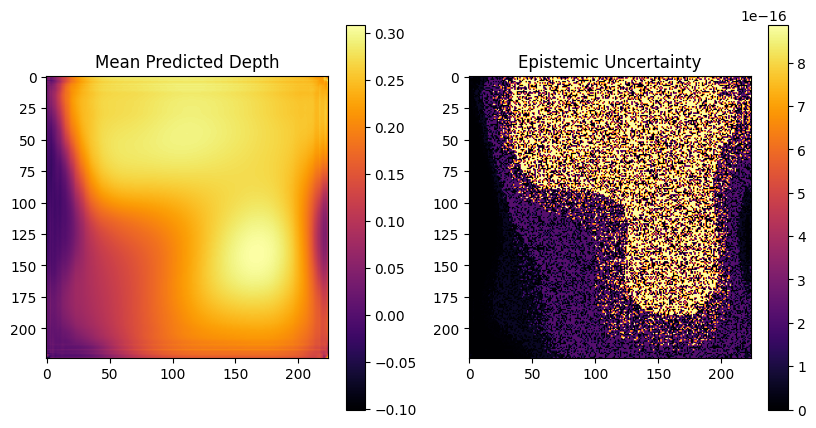

In [26]:
def mc_dropout(model, images, n_iter=10):
    model.train()  # Enable dropout layers during inference
    preds = []
    for _ in range(n_iter):
        pred_depths, _ = model(images)
        preds.append(pred_depths.cpu().numpy())
    preds = np.stack(preds, axis=0)  # Shape: (n_iter, batch, height, width)
    mean_pred = preds.mean(axis=0)
    epistemic_uncertainty = preds.var(axis=0)
    return mean_pred, epistemic_uncertainty

# Example usage
with torch.no_grad():
    for images, depths in test_dl:
        images = images.to(device)
        mean_depth, epistemic_uncertainty = mc_dropout(model, images, n_iter=10)
        
        # Visualize first sample
        mean_depth_sample = mean_depth[0].squeeze()
        uncertainty_sample = epistemic_uncertainty[0].squeeze()

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Mean Predicted Depth")
        plt.imshow(mean_depth_sample, cmap='inferno')
        plt.colorbar()


        plt.subplot(1, 2, 2)
        plt.title("Epistemic Uncertainty")
        plt.imshow(uncertainty_sample, cmap='inferno')
        plt.colorbar()

        plt.show()
        break


In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DepthUncertaintyModel().to(device)

# Load the pre-trained weights
model.load_state_dict(torch.load("depth_uncertainty_model.pth"))

# Set the model to training mode
model.train()

/Users/tueeee/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tueeee/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/0f/s9wq33q97413q_m4638c7wdr0000gn/T/ipykernel_16164/1637091223.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.c

DepthUncertaintyModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)  # Smaller learning rate
fine_tune_epochs = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DepthUncertaintyModel().to(device)

scaler = GradScaler()

for epoch in range(fine_tune_epochs):
    model.train()
    running_loss = 0.0
    for images, depths in tqdm(train_dl):
        images, depths = images.to(device), depths.to(device)
        optimizer.zero_grad()
        
        with autocast():
            pred_depths, log_var = model(images)
            loss = probabilistic_loss(pred_depths, depths, log_var)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    print(f"Fine-Tuning Epoch {epoch+1}/{fine_tune_epochs}, Loss: {running_loss/len(train_dl)}")


/var/folders/0f/s9wq33q97413q_m4638c7wdr0000gn/T/ipykernel_7500/2907435117.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/Users/tueeee/anaconda3/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/157 [00:00<?, ?it/s]

/var/folders/0f/s9wq33q97413q_m4638c7wdr0000gn/T/ipykernel_7500/2907435117.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fine-Tuning Epoch 1/3, Loss: 0.03611093063121009


  0%|          | 0/157 [00:00<?, ?it/s]

Fine-Tuning Epoch 2/3, Loss: 0.036301381126710566


  0%|          | 0/157 [00:00<?, ?it/s]

Fine-Tuning Epoch 3/3, Loss: 0.03632372366205142
